# Jet Engine Remaining Useful Life(RUL) Prediction

#### Dataset Description

**Data Set: FD001**
- Train trajectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: ONE (HPC Degradation)

**Data Set: FD002**
- Train trajectories: 260
- Test trajectories: 259
- Conditions: SIX 
- Fault Modes: ONE (HPC Degradation)

**Data Set: FD003**
- Train trajectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: TWO (HPC Degradation, Fan Degradation)

**Data Set: FD004**
- Train trajectories: 248
- Test trajectories: 249
- Conditions: SIX 
- Fault Modes: TWO (HPC Degradation, Fan Degradation)


Each dataset is a text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:
1)	unit number
2)	time, in cycles
3)	operational setting 1
4)	operational setting 2
5)	operational setting 3
6)	sensor measurement  1
7)	sensor measurement  2
and so on up to  sensor 26

#### Experimental Scenario
Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine � i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. 


#### Objective 
The objective is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

#### Sources
- Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, �Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation�, in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.
- Data Source: [Link](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)

![engine](../assets/Turbofan-operation-lbp.png)

# 0. Required Imports

In [49]:
import pandas as pd
import numpy as np

from statistics import mean
import warnings

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.pipeline import Pipeline

from sklearn.utils import resample
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor


from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [2]:
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Data Collection and Preprocessing

We will focus on *FD001* dataset which contains data for HPC Degradation at sea level.

The dataset *FD001* contains time series of 21 sensors and 3 settings of 100 units(turbofan engine).Each engine works normally at the beginning of each time series and fails at the end of the time series. Each row is a snapshot of the data taken during a single operation cycle.

Defining feature names

In [3]:
index_names = ["unit_number", "time_cycles"]
setting_names = ["setting_1", "setting_2", "setting_3"]
sensor_names = ["s_{}".format(i+1) for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

We have train data which we wil split into train and test in modelling part and we also have test data which will be used as validation set.

In [4]:
df_train = pd.read_csv("../CMaps/train_FD001.txt",sep='\s+',header=None,index_col=False,names=col_names)

df_valid = pd.read_csv("../CMaps/test_FD001.txt", sep='\s+',header=None,index_col=False,names=col_names)

y_valid = pd.read_csv("../CMaps/RUL_FD001.txt", sep='\s+',header=None,index_col=False,names=["RUL"])

Verifying the dimension of our experimental datasets.

In [5]:
for dataset in [df_train, df_valid, y_valid]:
    print(dataset.shape)

(20631, 26)
(13096, 26)
(100, 1)


Percentage of validation dataset

In [6]:
(len(df_valid) / (len(df_valid) + len(df_train)) * 100)

38.829424496694045

In [7]:
df_train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 2.Exploratory Data Analysis

### 2.1. Checking the missing values

In [8]:
df_train.isna().sum()

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64

**Observations:**
- No missing values detected

### 2.2. Train dataset description

In [9]:
df_train.describe()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [10]:
df_train.loc[:, ["unit_number", "time_cycles"]].describe()

,unit_number,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


**Observations:**
- 20631 total rows present
- unit_number range between 1 to 100 (min to max)
- mean and third percentile(50%) don't align correctly due to each unit having different max time_cycles.
- From time_cycles Engine which failed earliest did so after 108.80 cycles, whereas the engine which operated the longest broke down after 362 cycles.
- Average engine breaks between 199 and 206 cycles.

In [11]:
df_train.loc[:, "s_1":].describe().T

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


### 2.3. Visualizing Max time cycles for each unit

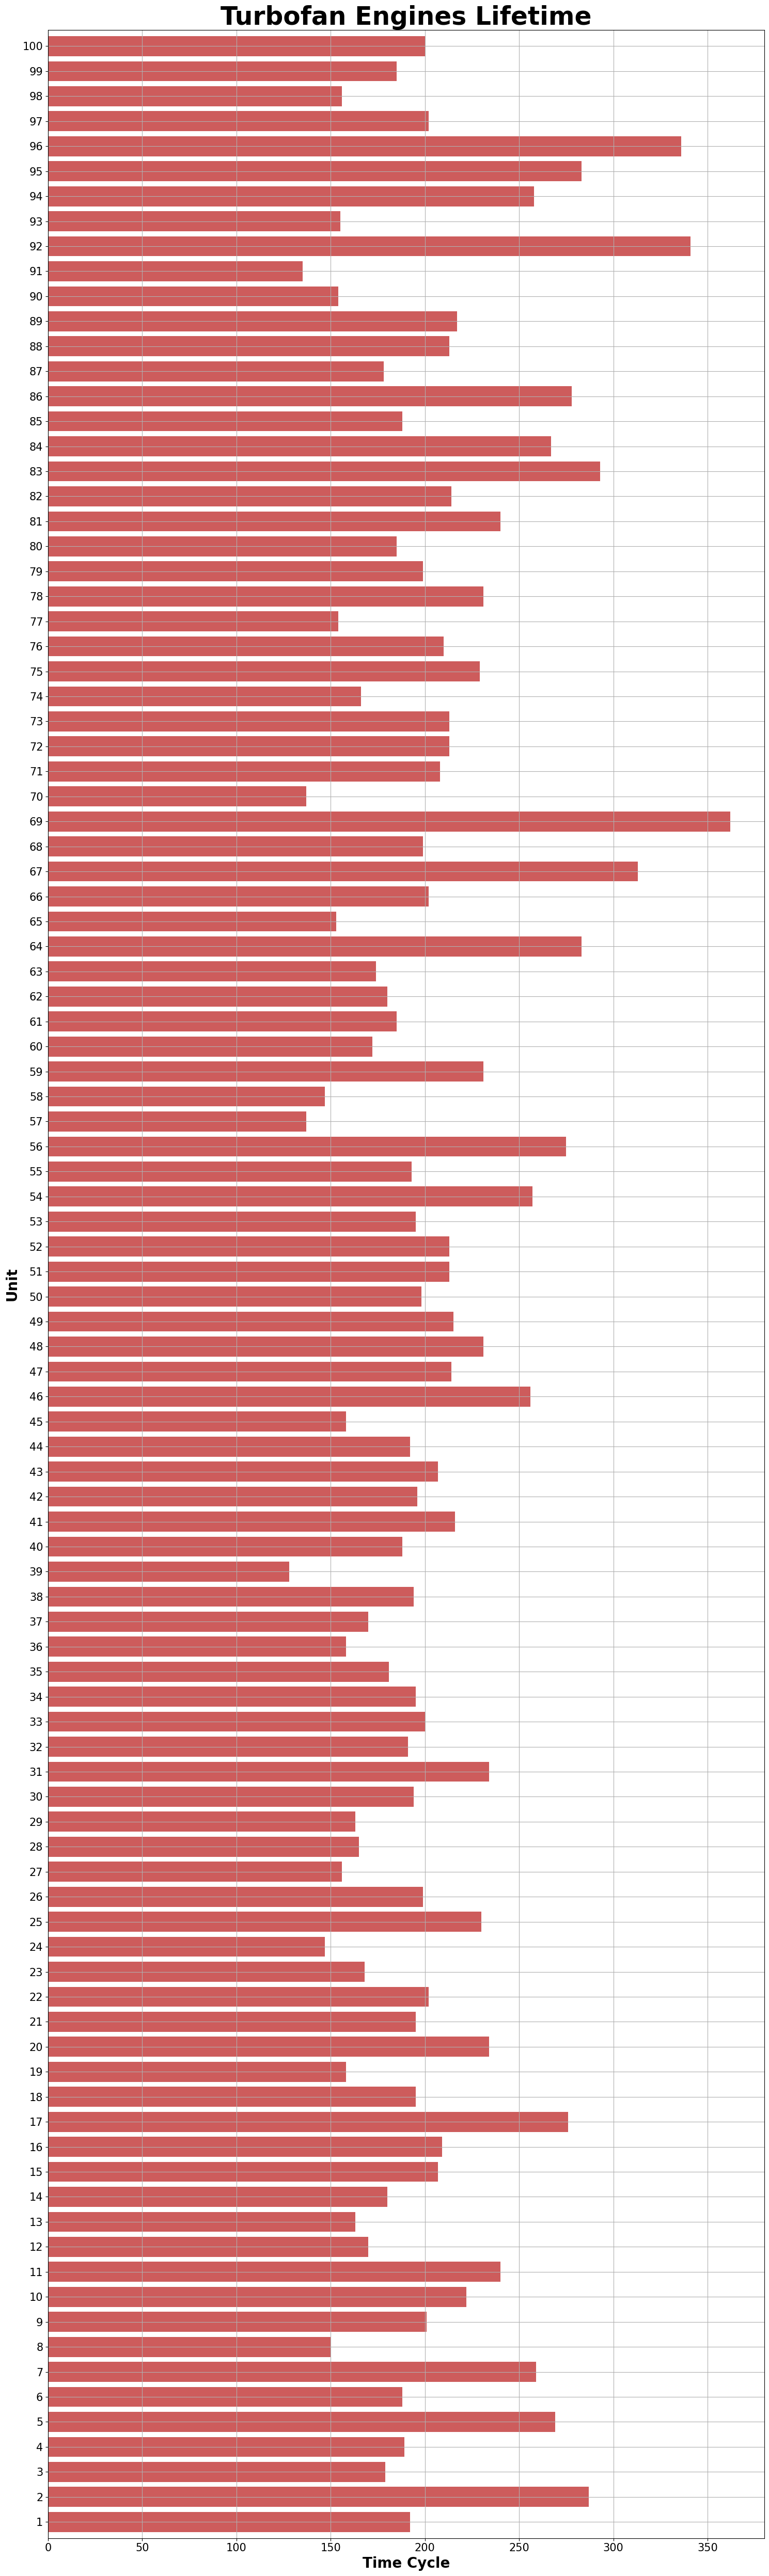

In [12]:
max_time_cycles = df_train[index_names].groupby("unit_number").max()

plt.figure(figsize=(15, 50))

ax = max_time_cycles["time_cycles"].plot(kind="barh", width=0.8, stacked=True, align="center", color="indianred")

plt.title("Turbofan Engines Lifetime", fontweight="bold", size=35)


plt.xlabel("Time Cycle", fontweight="bold", size=20)
plt.ylabel("Unit", fontweight="bold", size= 20)

plt.xticks(size=15)
plt.yticks(size=15)

plt.grid(True)
plt.tight_layout()
plt.show()

### 2.4. Distribution of Maximum time cycles

Text(0.5, 0, 'Max Time Cycles')

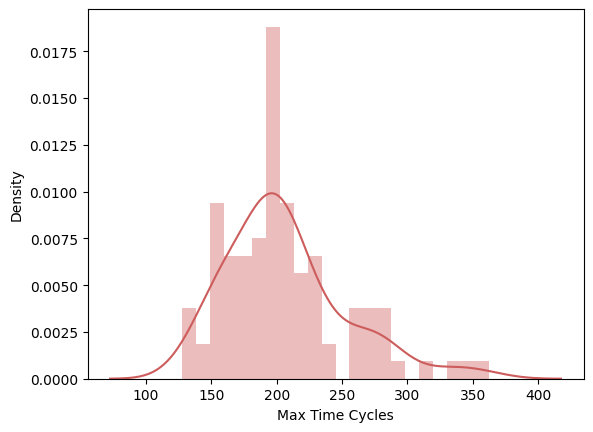

In [13]:
sns.distplot(max_time_cycles["time_cycles"], kde=True, bins=22, color="indianred")

plt.xlabel("Max Time Cycles")

**Observations:**
- Most of the time maximum time cycles that an engine can achieve is between 190 and 210 before HPC failure.

### 2.5. Introducing RUL to the dataset

RUL corresponds to the remaining time cycles for each unit before it fails or reaches the max time cycles before HPC failure.

In [14]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number') 

    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 

    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)

    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']

    merged = merged.drop("max_time_cycle", axis=1) 
    
    return merged

In [15]:
df_train = add_RUL_column(df_train)

In [16]:
df_train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### 2.6. Correlation Analysis

<AxesSubplot: >

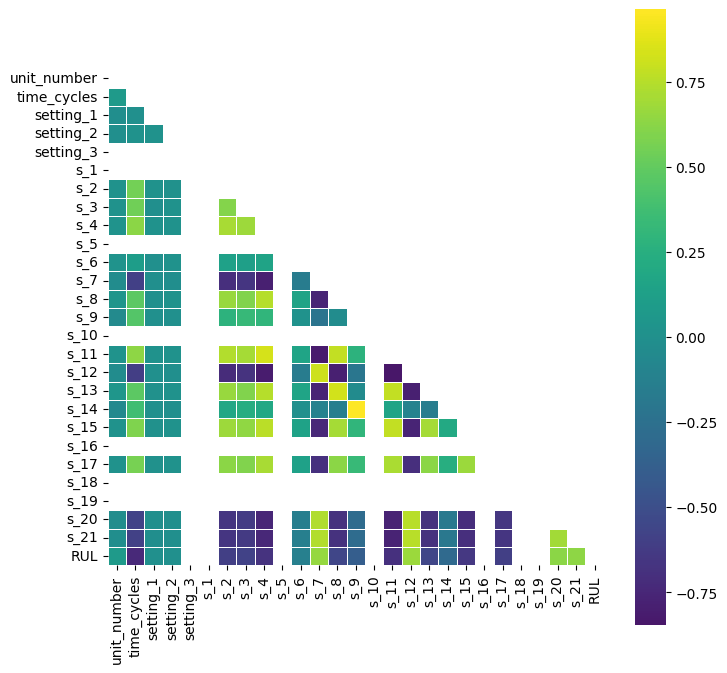

In [17]:
plt.figure(figsize=(8, 8))

mask = np.triu(np.ones_like(df_train.corr(), dtype=bool))


sns.heatmap(df_train.corr(), cmap="viridis", mask=mask, center=0, linewidths=0.6, square=True)

**Observations:**
- Some features are highly correlated with target feature(RUL).
- Some features have very low correlation with target feature.

### 2.7. Visualizing evolution of features(sensor) with RUL

Matching sensor with real significance.

In [18]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1

In [19]:
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

A low pressure compressor (LPC) and high pressure compressor (HPC) supply compressed high temperature, high pressure gases to the combustor. Low pressure turbine (LPT) can decelerate and pressurize air to improve the chemical energy conversion efficiency of aviation kerosene. High pressure turbines (HPT) generate mechanical energy by using high temperature and high pressure gas strike turbine blades. Low-pressure rotor (N1), high-pressure rotor (N2), and nozzle guarantee the combustion efficiency of the engine.

In [20]:
def plot_signal(df, sensor_dict, signal_name):
    "Function to plot the signal or sensor data vs RUL"
    plt.figure(figsize=(10,4))
    
    for i in df['unit_number'].unique():
        # Plot sensor signals with 20 units size only for better visuals
        if (i % 10 == 0):   
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    # Reverse the x-axis so RUL counts down to zero
    plt.xlim(250, 0)  

    plt.xticks(np.arange(0, 300, 25))
    
    plt.ylabel(sensor_dict[signal_name])
    plt.xlabel('Remaining Useful Life')
    
    plt.show()

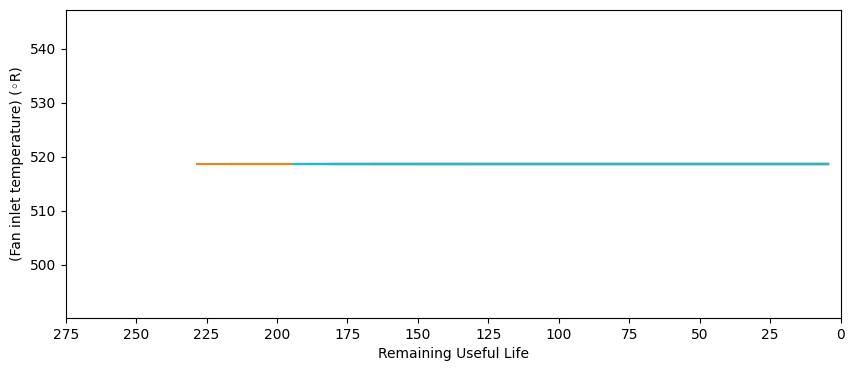

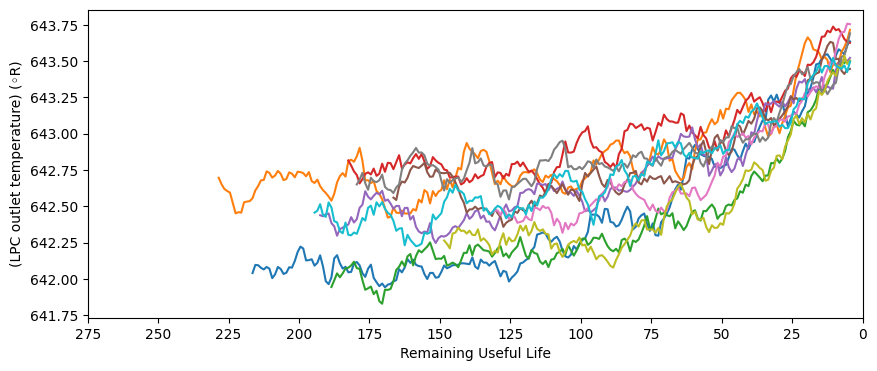

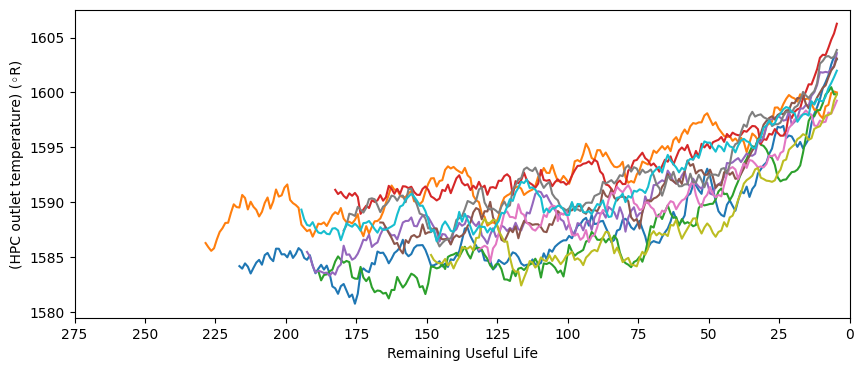

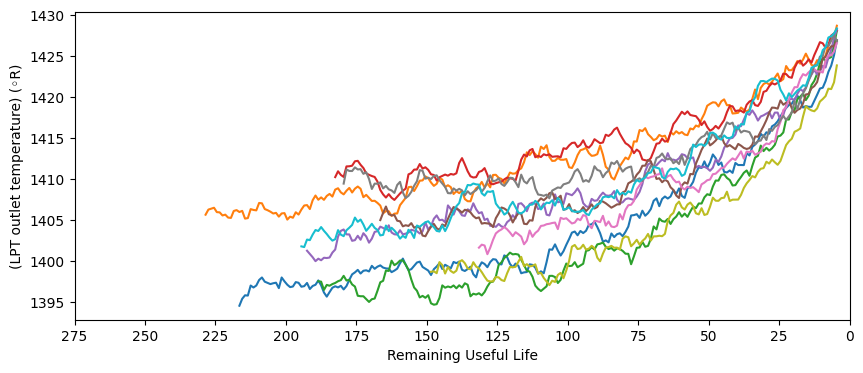

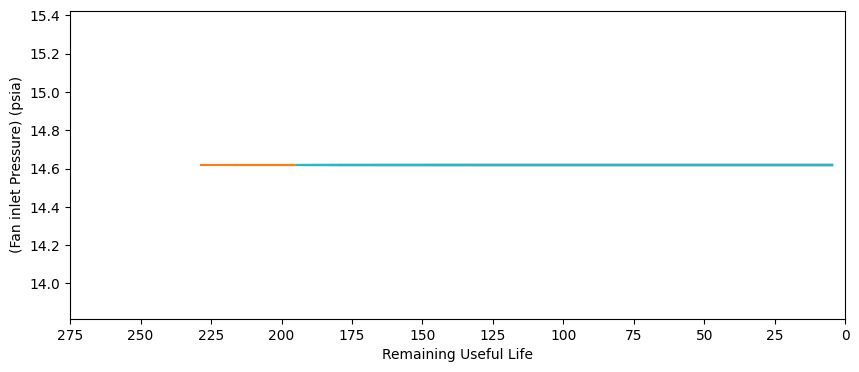

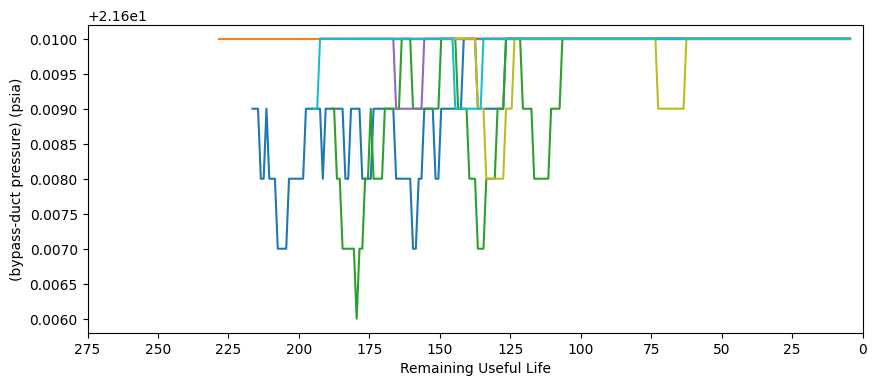

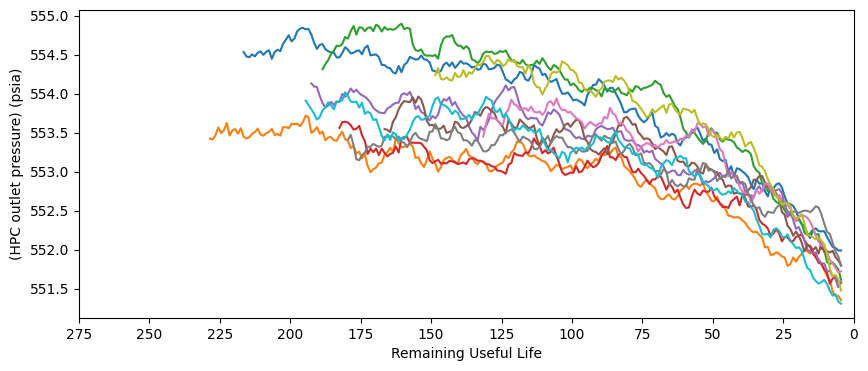

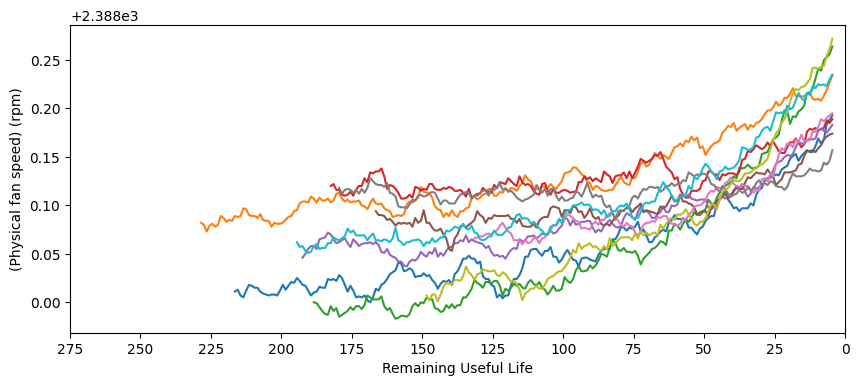

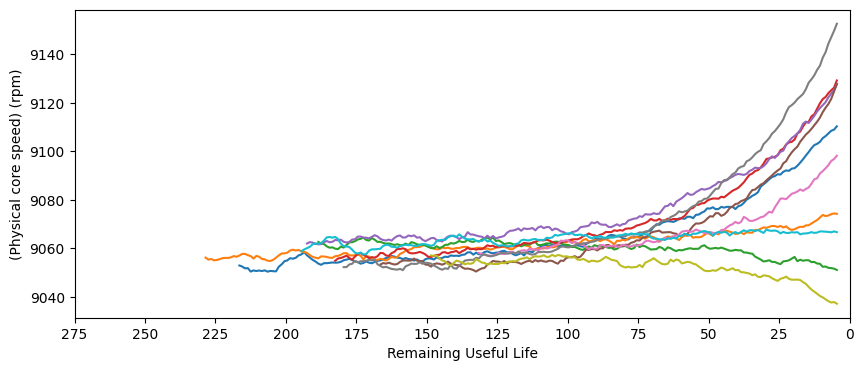

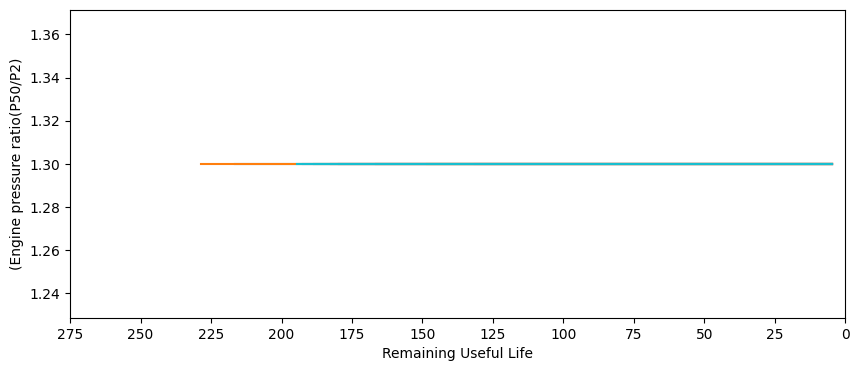

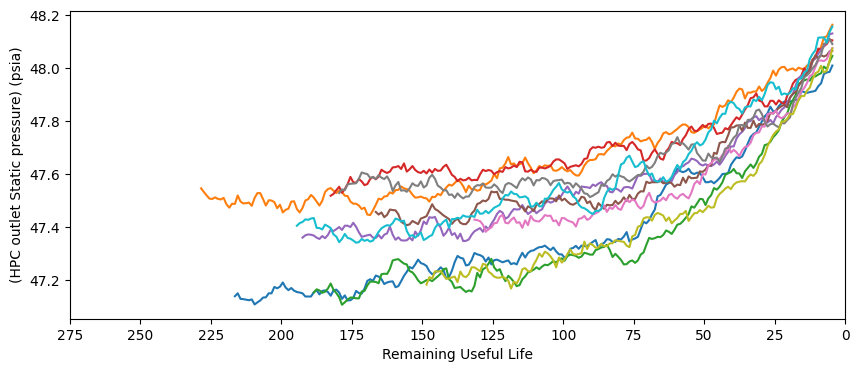

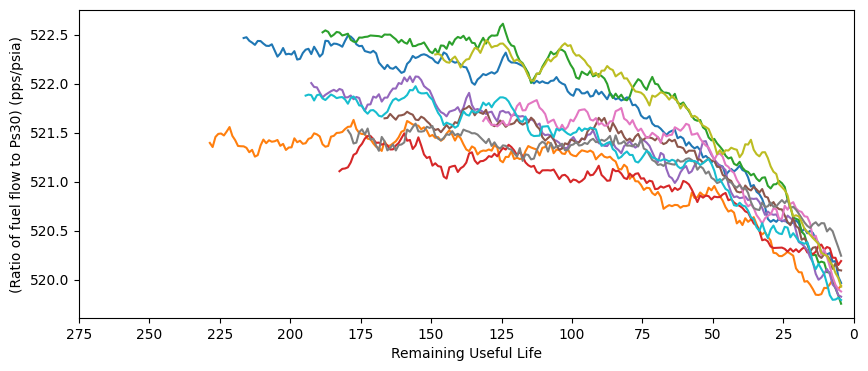

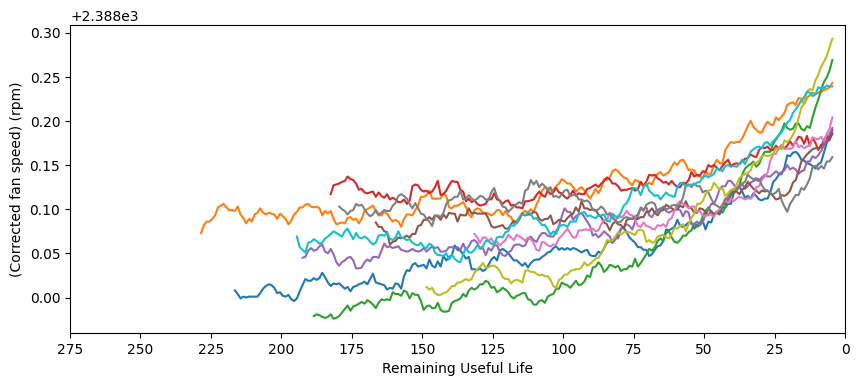

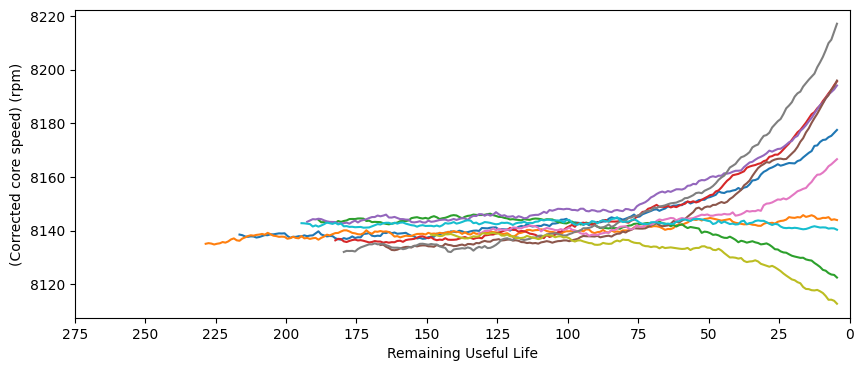

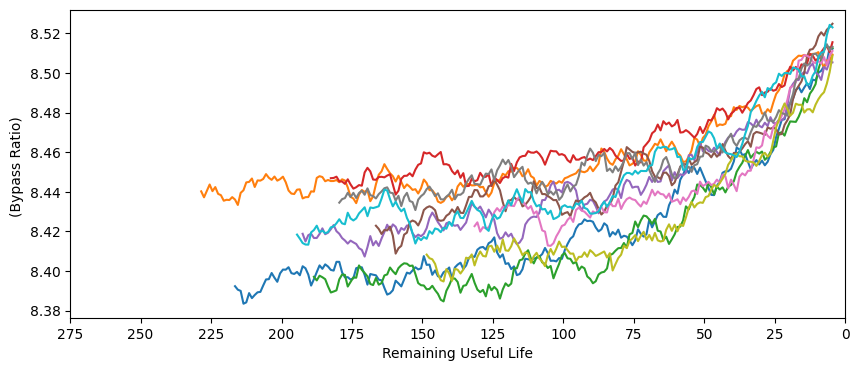

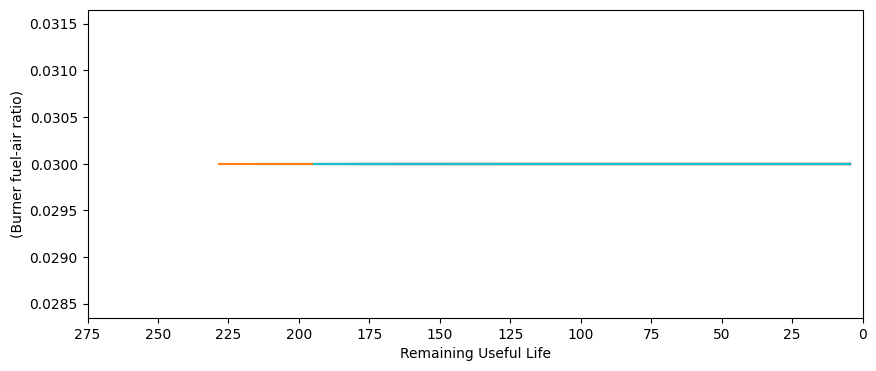

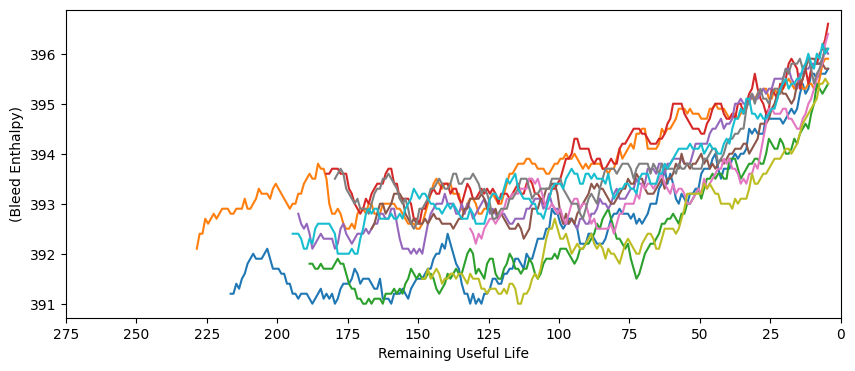

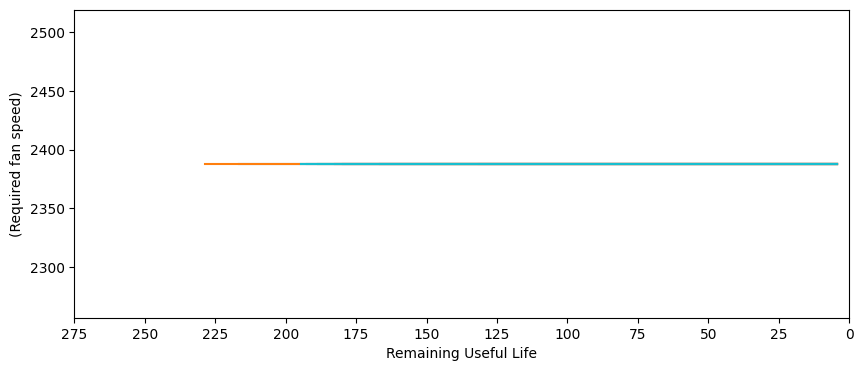

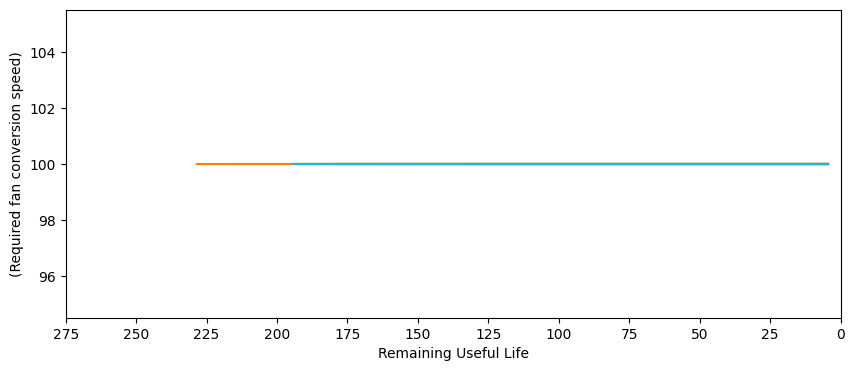

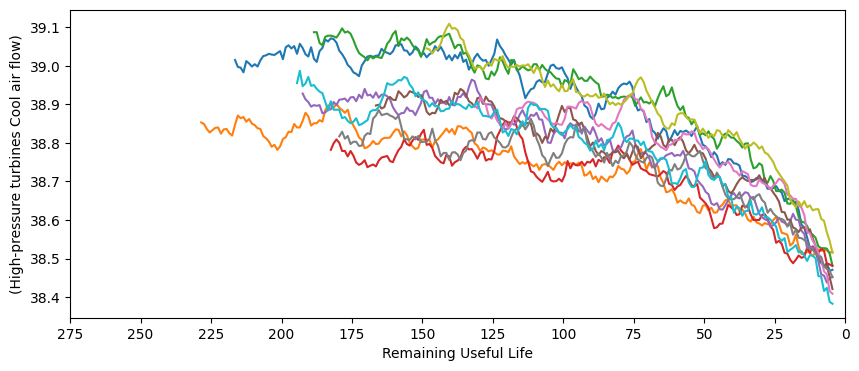

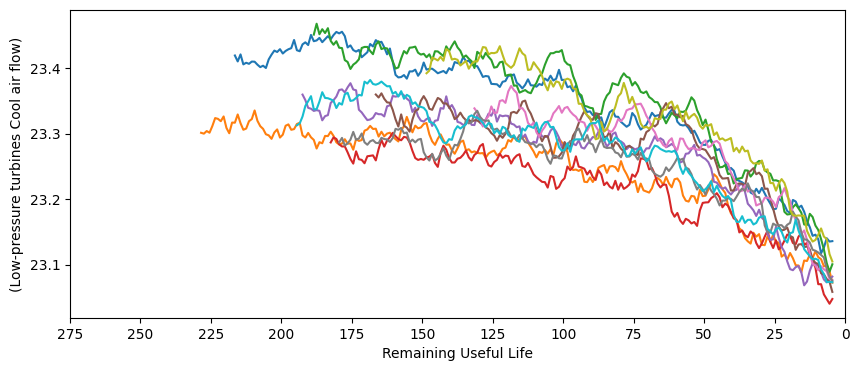

In [21]:
for i in range(1,22):
    try:
        plot_signal(df_train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

**Observations:**
- Few of the sensors are constant and don't influence the RUL so we will drop them.

### 2.8. Detecting outliers in sensors feature of training data

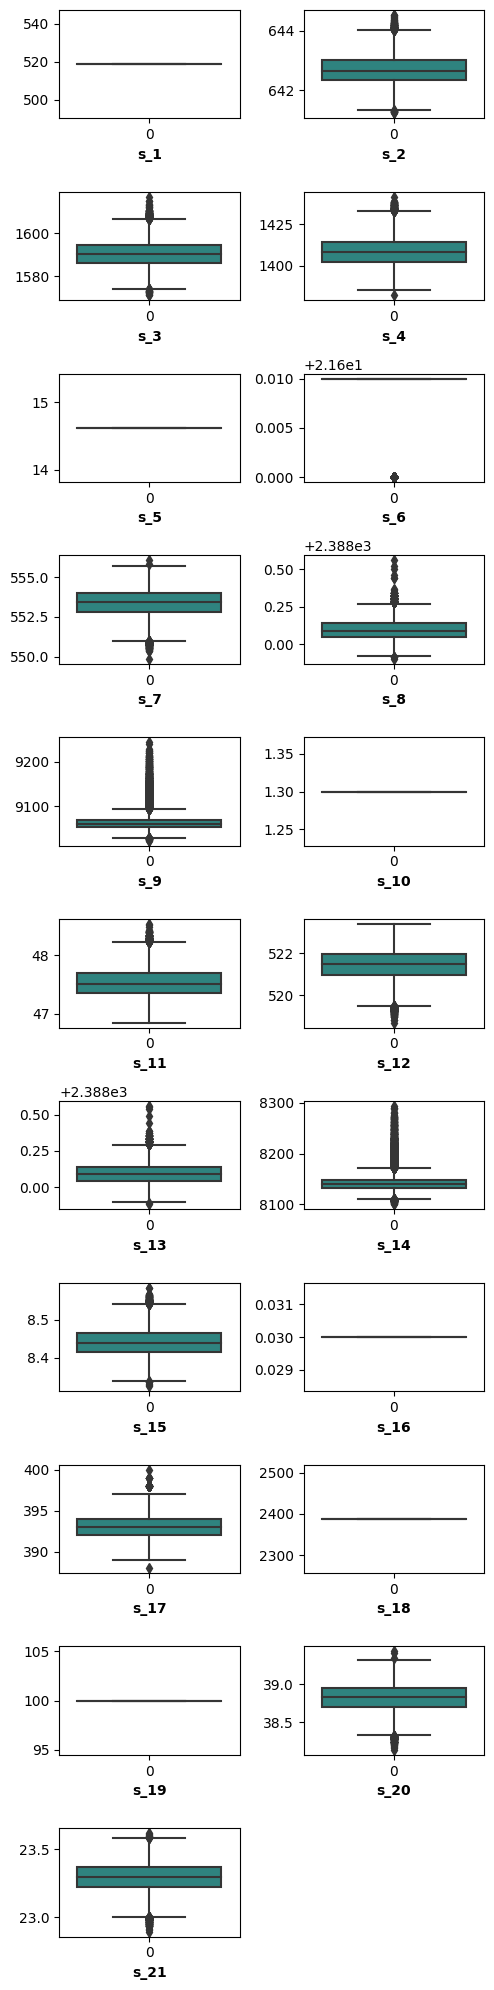

In [22]:
n = 1

plt.figure(figsize=(5, 20))

for sensor in sensor_names:
    plt.subplot(11,2, n)
    n+=1
    sns.boxplot(df_train[sensor], palette="viridis")
    plt.xlabel(xlabel=sensor, weight="bold")
    plt.tight_layout()

**Observations:**
- Outliers detected in various sensor data so we need to scale those features to treat them.
- Some sensor data are indeed constant, we can confirm it from sensor graphs in section 2.7 and 2.8.
- Constant sensors are 1, 5, 10, 16, 18, 19.

## 3. Model Training and Evaluation

### 3.1. Score calculation method 

It calculates accuracy score, F1 score, precision score, recall score, ROC_AUC score for given truth values and predicted values for a *specific model*.

In [24]:
def cal_scores(true, predicted):
    ''' 
    true: true values 
    predicted: predicted values
    -------------------------------------------------------------
    returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''

    acc = accuracy_score(true, predicted) 
    f1 = f1_score(true, predicted) 
    precision = precision_score(true, predicted) 
    recall = recall_score(true, predicted)  
    roc_auc = roc_auc_score(true, predicted) 

    return acc, f1 , precision, recall, roc_auc

### 3.2. Cost calculation method

It calculates the total misclassification cost of specified model on the given true and predicted values.


We could observe that, we have to reduce false positives and false negatives while predicting RUL. More importantly we have to reduce false negatives, since cost incurred due to false negative is much times higher than the false positives.

Its given by the client that we need 10 instances of false positive for 500 instances of false negative.

```
Total Cost = Cost_1 * N_instances + Cost_2 * N_instances
```

In [28]:
def total_cost(y_true, y_pred):
    '''
    y_true: true values
    y_predicted: predicted values
    -------------------------------------
    return: cost due to misclassification
    '''

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    
    return cost

### 3.3. Model evaluation method

Model evaluation function evaluates scores and cost using ```cal_scores``` and ```total_cost``` function for each ```models``` and returns a ```dataframe``` with all the reports.

In [30]:
def evaluate_models(X, y, models):
    '''
    X: input features dataframe
    y: target features dataframe
    models: dictionary containing model name as key and model object as value
    -------------------------------------------------------------------------
    returns: Dataframe which contains report of all models metrics with cost
    '''

    # Split the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    # Initializing the cost, models, accuracy list 
    cost_list=[]
    models_list = []
    accuracy_list = []
    

    #  Iterate through the models and evaluates the metrics for each model
    for i in range(len(list(models))):

        # get model object from models
        model = list(models.values())[i]
        
        # Train the model
        model.fit(X_train, y_train) 


        # Make predictions for train and test set
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)


        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall, model_train_roc_auc_score = cal_scores(y_train, y_train_pred)
        
        train_cost = total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy, model_test_f1, model_test_precision, model_test_recall, model_test_roc_auc_score = cal_scores(y_test, y_test_pred)

        test_cost = total_cost(y_test, y_test_pred)


        # Displaying Metrics for each model 
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_roc_auc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_roc_auc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')

    

    # Creating report data frame    
    report = pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report

## 4. Experiments

We will evaluate all teh models after performing different experiments with variety of ```imputation```, ```scaling``` and ```sampling``` techniques. 

**Input and target feature segregation**

In [41]:
X = df_train.drop("RUL", axis=1)
y = df_train["RUL"]

**Performing train test split of train data before experimentation**

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**Models to experiment on**

In [47]:
models = {
    "Random Forest Regressor": RandomForestRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Logistic Regressor": LogisticRegression(),
     "K-Neighbors Regressor": KNeighborsRegressor(),
    "XGB Regressor": XGBRegressor(), 
     "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

### 4.1. With all sensor data and no historical data

#### 4.1.1. With KNN Imputer, Robust Scaler, SMOTE & TOMEK Resampling

Creating robust scaler object and fit transforming the input features using that object.

In [104]:
X_train.shape, y_train.shape

((13822, 26), (13822,))

In [105]:
type(X_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [109]:
a = pd.DataFrame(y_train)

In [111]:
a.shape, type(a)

((13822, 1), pandas.core.frame.DataFrame)

In [113]:
robust_scaler = RobustScaler()
X1 = robust_scaler.fit_transform(X_train)
#y1 = robust_scaler.transform(y_train.to_frame())

In [115]:
y_train.head()

20118    127
1225      78
6408       3
16870     14
13583     47
Name: RUL, dtype: int64

In [116]:
y_train.__len__

<bound method Series.__len__ of 20118    127
1225      78
6408       3
16870     14
13583     47
        ... 
11284    107
11964    162
5390      74
860      255
15795    157
Name: RUL, Length: 13822, dtype: int64>

Iterates through different K values and finding the optimal n_neighbor value for KNN imputer.

In [114]:
results=[]

# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')


# defined strategies or k values to iterate over 
strategies = [str(i) for i in [1,3,5,7,9]]

# iterating for k values in strategies
for s in strategies:
    # defining pipeline using KNNImputer and LogisticRegression model 
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])

    # calculating scores for each k value of the LogisticRegression model
    scores = cross_val_score(pipeline, X1, y_train, scoring='accuracy', cv=2, n_jobs=-1)

    # appending the results with scores for each k
    results.append(scores)

    # displaying score for each k
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

n_neighbors= 1 || accuracy (0.0176)
n_neighbors= 3 || accuracy (0.0176)
n_neighbors= 5 || accuracy (0.0176)
n_neighbors= 7 || accuracy (0.0176)
n_neighbors= 9 || accuracy (0.0176)


### 4.2. Without useless sensors and no historical data

### 4.3. Without useless sensors and historical data

In [31]:
df_train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
